In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

dir0 = Path('el_nino/')
file_sst = 'sst.mnmean.nc'
file_2 = 'mslp_coarse.nc'

# load the data set with xarray
ds_nino = xr.open_dataset(Path(dir0, file_sst))
ds_mslp = xr.open_dataset(Path(dir0, file_2))

# define 3.4 region
lat_min, lat_max = -5.5, 5.5
lon_min, lon_max = 190, 240

# Interpolating to get rid of the nan-values
ds_nino = ds_nino.interpolate_na(dim='lon')
ds_mslp = ds_mslp.interpolate_na(dim='lon')

# Select the region
ds_region_nino = ds_nino.where((ds_nino.lat >= lat_min) & (ds_nino.lat <= lat_max) & 
                               (ds_nino.lon >= lon_min) & (ds_nino.lon <= lon_max), drop=True)
ds_region_mslp = ds_mslp.where((ds_mslp.latitude >= lat_min) & (ds_mslp.latitude <= lat_max) & 
                               (ds_mslp.longitude >= lon_min) & (ds_mslp.longitude <= lon_max), drop=True)

In [6]:
# Extracting the labels from 01/1982 to 05/2021
# -2 = Strong La Nina
# -1 = La Nina
# 0 = Nothing
# 1 = El Nino
# 2 = Strong El Nino

pred_2023 = {}

# Initialisation
start_date_y = pd.Timestamp(year = 1982, month = 1, day = 1)
end_date_y = pd.Timestamp(year = 2021, month = 5, day = 1)
current_date = start_date_y

# In the end we want to predict what is going to happen in 2023
pred_start_date_y = pd.Timestamp(year = 2023, month = 1, day = 1)
pred_end_date_y = pd.Timestamp(year = 2023, month = 12, day = 1)

# Mean temperature in the region over all the years
big_mean = float(ds_region_nino.mean()['sst'])

ys = []

while current_date <= end_date_y:
    # print(current_date)

    # Create Timestamps for previous, current, and next months
    current_month = current_date
    prev_month = current_month - pd.DateOffset(months = 1)
    next_month = current_month + pd.DateOffset(months = 1)

    # Get data for each month
    ds_prev_month = ds_region_nino.sel(time = slice(prev_month, prev_month))
    ds_curr_month = ds_region_nino.sel(time = slice(current_month, current_month))
    ds_next_month = ds_region_nino.sel(time = slice(next_month, next_month))

    # Merge the three datasets
    merged_dataset = xr.concat([ds_prev_month, ds_curr_month, ds_next_month], dim='time')

    # Calculate the average sea surface temperature along the time dimension
    sst_anom = float(merged_dataset['sst'].mean()) - big_mean
    # print(current_date, ': ', sst_anom)
    cases = [
        (sst_anom >= 0.5),
        (sst_anom < 0.5) & (sst_anom > -0.5),
        (sst_anom <= -0.5),
    ]
    conditions = [1, 0, -1]
    res = np.select(cases, conditions, 0)

    ys.append(res)
    
    # Increment to the first day of the next month
    current_date += pd.DateOffset(months = 1)

# Convert the list to a numpy array
ys_np = np.array(ys)

# trying to predict El Nino
for n_month in range(1,2):
    
    # Dataset to predict n_month in advance using 1 year of data
    start_date_X = start_date_y - pd.DateOffset(years = 1) - pd.DateOffset(months = n_month - 1)
    end_date_X = end_date_y - pd.DateOffset(years = 1) - pd.DateOffset(months = n_month - 1)
    current_date = start_date_X

    # # Dataset to make the prediction for 2023
    # pred_start_date_X = pred_start_date_y - pd.DateOffset(years = 1) - pd.DateOffset(months = n_month - 1)
    # pred_end_date_X = pred_end_date_y - pd.DateOffset(years = 1) - pd.DateOffset(months = n_month - 1)
    # current_date_pred = pred_start_date_X

    xs_np = {}
    # xs_np_pred ={}

    while current_date <= end_date_X:
        
        start_variable = current_date
        end_variable = current_date + pd.DateOffset(years = 1) - pd.DateOffset(months = 1)
        # print(start_variable, ' => ', end_variable)

        # Selecting the data for the one-year interval
        interval_data = ds_mslp.sel(time=slice(start_variable, end_variable))

        # Formatting the interval data
        numpy_array = interval_data['msl'].to_numpy()
        flattened_data = numpy_array.flatten()
        xs_np[str(end_variable.year) + "/" + str(end_variable.month + n_month)] = flattened_data
        # print(str(end_variable.year) + "/" + str(end_variable.month + n_month))

        # Increment to the first day of the next month
        current_date += pd.DateOffset(months = 1)
    
    # Extracting the data to predict 2023
    # while current_date_pred <= pred_end_date_X:
    
    #     start_variable = current_date_pred
    #     end_variable = current_date_pred + pd.DateOffset(years = 1) - pd.DateOffset(months = 1)
    #     print(start_variable, ' => ', end_variable)

    #     # Selecting the data for the one-year interval
    #     interval_data = ds_mslp.sel(time=slice(start_variable, end_variable))

    #     # Formatting the interval data
    #     numpy_array = interval_data['msl'].to_numpy()
    #     flattened_data = numpy_array.flatten()
    #     xs_np_pred[str(end_variable.year) + "/" + str(end_variable.month + n_month)] = flattened_data
    #     # print(str(end_variable.year) + "/" + str(end_variable.month + n_month))

    #     # Increment to the first day of the next month
    #     current_date_pred += pd.DateOffset(months = 1)

    xs_np = np.array(list(xs_np.values()))
    # xs_np_pred = np.array(list(xs_np_pred.values()))



    # Training the Model:

    X_train, X_test, y_train, y_test = train_test_split(xs_np, ys_np, test_size  = 0.2, random_state = 42)

    # Create a pipeline with preprocessing and SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components = 0.95)), 
        ('lda', LinearDiscriminantAnalysis()),
        ('svm', SVC(kernel='rbf', c = 0.3, gamma = 0.01))
    ])

    # Stratified K-Fold Cross-Validation
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    # Cross-validation scores
    scores = cross_val_score(pipeline, xs_np, ys_np, cv = kfold)

    print ('predicting ', n_month, 'months in advance:')
    print("Cross-validation scores:", scores)
    print("Average score:", np.mean(scores))
    print('------------------------------------')

# pred_2023 = np.array(list(pred_2023.values()))
# print(pred_2023)

# prediction 2023: 0, 0, 0, 0/1, 1, 1, 1, 0, -1, -1, 0/-1, 0/-1
# should be:      -1, 0, 0,  0,  0, 1, 1, 1,  2,  2,  ?,   ?

predicting  1 months in advance:
Cross-validation scores: [0.8        0.69473684 0.67368421 0.70212766 0.71276596]
Average score: 0.7166629339305712
------------------------------------


(473, 4)
(12, 4)


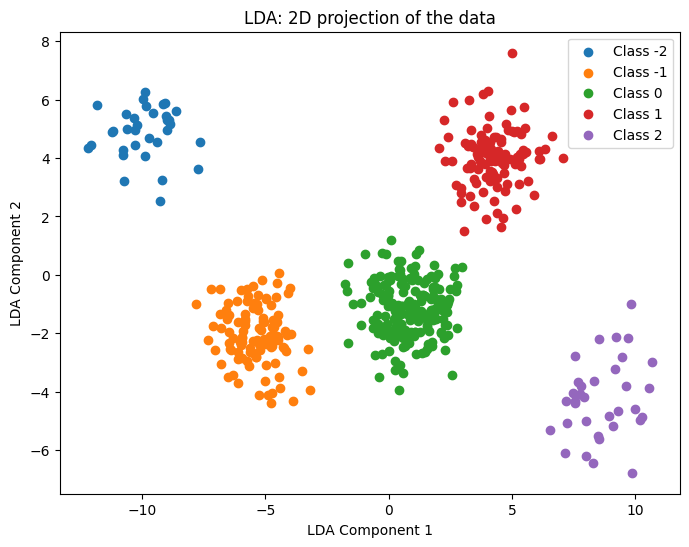

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


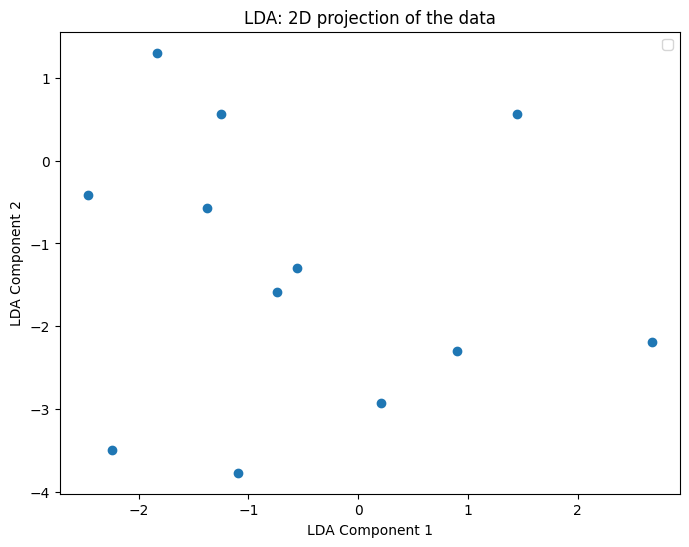

In [20]:
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(xs_np)

# Apply PCA
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

# Apply LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_pca, ys_np)

plt.figure(figsize=(8, 6))
for class_value in np.unique(ys_np):
    # Select indices of class
    indices = np.where(ys_np == class_value)
    # Plot those points with a specific color
    plt.scatter(X_lda[indices, 0], X_lda[indices, 1], label=f"Class {class_value}")

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA: 2D projection of the data')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_lda_pred[:, 0], X_lda_pred[:, 1])
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA: 2D projection of the data')
plt.legend()
plt.show()
